In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import storage

project_id = "sharp-matter-449521-u2"
!gcloud config set project {project_id}

Updated property [core/project].


In [3]:
!wget -P /usr/lib/spark/jars/ https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar

--2025-04-24 03:31:08--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  38.83M   142MB/s    in 0.3s    

2025-04-24 03:31:08 (142 MB/s) - ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’ saved [40713341/40713341]



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .getOrCreate()

# K-means Clustering

In [8]:
import pandas as pd
df_ca_pd = pd.read_csv('gs://final_dataset_dat490/df_ca_pd.csv')
df_ca_pd

gmap_id    customer_name  rating  \
0       0x100277924bd075cf:0x580587e75a2e5930      pdangelo4 D       5   
1       0x14e035bf1d6e56af:0x4b5a1833b3b81a05      Bill Taylor       5   
2       0x14e17823cf45b877:0x51beb951786095fc     Nora Elfassi       5   
3       0x14e1783b3ea4ac25:0xf80967990e6cfae4      James Whyte       4   
4       0x14e17940e6ecd36f:0xf82c7160bbe14c8f   Mike Blanchard       5   
...                                       ...              ...     ...   
306380  0x89c254c644e96bcd:0x1639f94a5ddba5e6        Renee Ray       4   
306381  0x89c2984884ddacbb:0x2f86b4fc0b9352f4      Julie Hsieh       5   
306382  0x89c624a51b8bc7b7:0xa131bcf9dc1ed36a       Haley Hill       5   
306383  0x89d312304c2eba19:0x1f0feb9ba12e4a1e          L Scott       5   
306384  0x89e4bb7c470ffaf5:0xb86a6e5f2b6d1ec9  Halima Crenshaw       1   

                                                  reviews           time  \
0       Great food, great price for the location, grea...  1499130935024   
1       The spot is first-rate and spacious, the meals...  1616517663786   
2       We were visiting long beach and it was mother'...  1561056772859   
3       Nice guys. Excellent crust. Good cheese.  I wi...  1619848194853   
4       This place is awesome. Great place to ride, bo...  1602873670030   
...                                                   ...            ...   
306380  This office is fairly easy in and great locati...  1581464356371   
306381  So sad to see iconic American store being boug...  1592275561488   
306382  As a photographer, I've gotten to work pretty ...  1586989353540   
306383  The food is amazing! Like seriously if you're ...  1547411188107   
306384  I got really good deals but I gave this a 2 be...  1573798325698   

        avg_rating                                           category  \
0              4.2                             Greek restaurant, Cafe   
1              4.5  Thai restaurant, Asian restaurant, Southeast A...   
2              3.6   Southern restaurant (US), Bakery, Cafe, Wine bar   
3              4.5  Pizza restaurant, Italian restaurant, Delivery...   
4              4.7                                              Ranch   
...            ...                                                ...   
306380         2.7                             Social security office   
306381         4.3  Jewelry store, Gift shop, Jewelry designer, Je...   
306382         4.2  Magazine store, Advertising agency, Newspaper ...   
306383         4.2                     Seafood restaurant, Restaurant   
306384         4.3  Women's clothing store, Clothing store, Jeans ...   

         latitude   longitude                      business_name  ...  Friday  \
0       32.709388 -117.171960                 Greek Islands Cafe  ...     1.0   
1       34.179015 -119.177052         Suvarnaphumi Thai Cuisine.  ...     1.0   
2       33.770632 -118.187538                Sweet Dixie Kitchen  ...     1.0   
3       33.766830 -118.006851                 Big Rob's Pizzeria  ...     1.0   
4       33.727337 -117.648606                     Circle S Ranch  ...     1.0   
...           ...         ...                                ...  ...     ...   
306380  38.729066 -121.275065  US Social Security Administration  ...     NaN   
306381  34.058235 -118.418263                      Tiffany & Co.  ...     1.0   
306382  32.715567 -117.142957                   San Diego Reader  ...     1.0   
306383  33.989595 -118.463722                           Salt Air  ...     NaN   
306384  38.767505 -121.268583                            Chico's  ...     1.0   

       Saturday Sunday            timestamp  week  month  year  time_seconds  \
0           1.0    1.0  2017-07-04 01:15:35    27      7  2017    1499130935   
1           1.0    1.0  2021-03-23 16:41:03    12      3  2021    1616517663   
2           1.0    1.0  2019-06-20 18:52:52    25      6  2019    1561056772   
3           1.0    1.0  2021-05-01 05:49:54    17      5  2021    

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Define features for clustering
features = ["avg_rating", "num_of_reviews", "label"]

# Drop rows with missing data
df_kmeans = df_ca_pd.dropna(subset=features).copy()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_kmeans[features])

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
df_kmeans["cluster"] = kmeans.fit_predict(scaled_features)

In [10]:
df_kmeans.groupby("cluster")[features].mean().round(2)

avg_rating  num_of_reviews  label
cluster                                   
0              3.26          131.66   1.36
1              4.43          181.28   2.00
2              4.23          201.05   0.63
3              4.36         3003.97   1.65

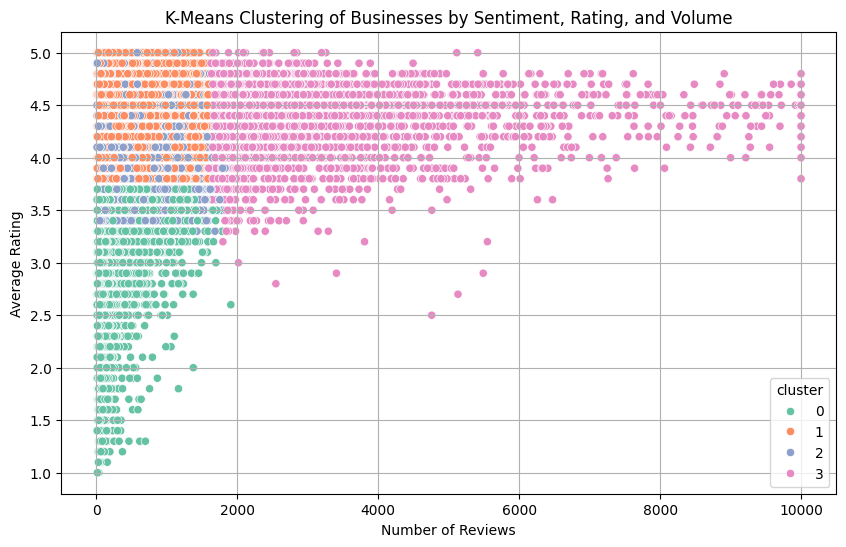

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_kmeans,
    x="num_of_reviews",
    y="avg_rating",
    hue="cluster",
    palette="Set2"
)
plt.title("K-Means Clustering of Businesses by Sentiment, Rating, and Volume")
plt.xlabel("Number of Reviews")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()

In [12]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Prepare data
df_cluster = df_ca_pd[["label", "avg_rating", "num_of_reviews"]].dropna().copy()

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cluster)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster["cluster"] = kmeans.fit_predict(scaled_features)

# Create interactive 3D plot
fig = px.scatter_3d(
    df_cluster,
    x="label",
    y="avg_rating",
    z="num_of_reviews",
    color="cluster",
    title="📊 3D Clustering by Sentiment, Rating, and Review Volume",
    labels={
        "label": "Sentiment Label",
        "avg_rating": "Average Rating",
        "num_of_reviews": "Number of Reviews",
        "cluster": "Cluster"
    },
    color_continuous_scale=px.colors.qualitative.Set2
)

fig.update_layout(
    legend_title_text='Cluster',
    scene=dict(
        xaxis_title='Sentiment Label',
        yaxis_title='Average Rating',
        zaxis_title='Number of Reviews'
    )
)

fig.show()

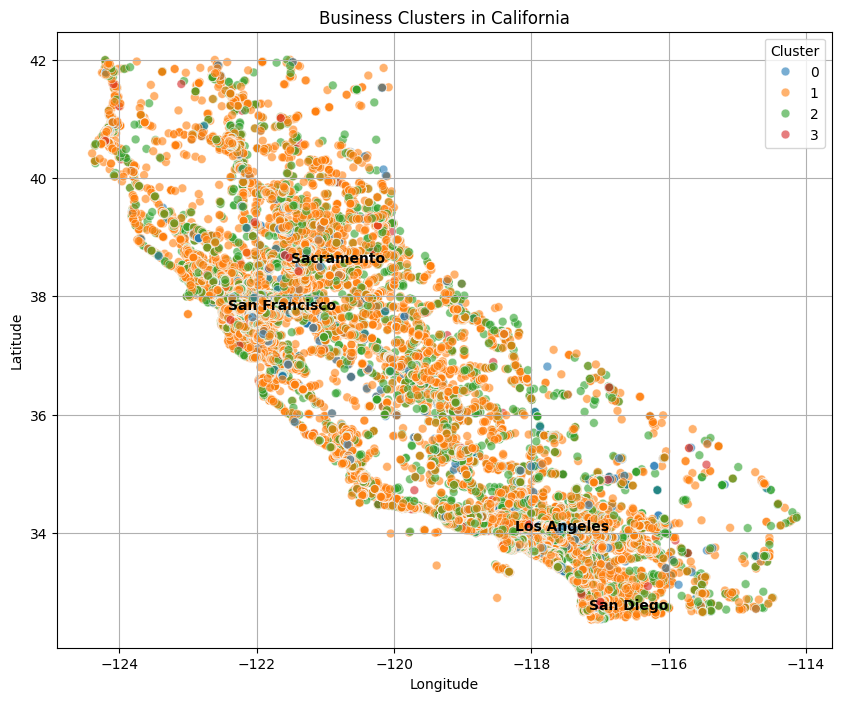

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop outliers
df_kmeans = df_kmeans[
    (df_kmeans["longitude"] >= -125) & (df_kmeans["longitude"] <= -113) &
    (df_kmeans["latitude"] >= 32) & (df_kmeans["latitude"] <= 43)
]

# City labels
city_coords_ca = {
    "Los Angeles": (-118.2437, 34.0522),
    "San Francisco": (-122.4194, 37.7749),
    "San Diego": (-117.1611, 32.7157),
    "Sacramento": (-121.4944, 38.5816)
}

# Plot
plt.figure(figsize=(10, 8))
palette = sns.color_palette("tab10", n_colors=df_kmeans["cluster"].nunique())

sns.scatterplot(
    data=df_kmeans,
    x="longitude",
    y="latitude",
    hue="cluster",
    palette=palette,
    alpha=0.6,
    s=40
)

# Add city labels
for city, (lon, lat) in city_coords_ca.items():
    plt.text(lon, lat, city, fontsize=10, weight="bold")

plt.title("Business Clusters in California")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(title="Cluster", loc="upper right")
plt.show()

Text(0.5, 1.0, 'Struggling businesses (Cluster 0)')

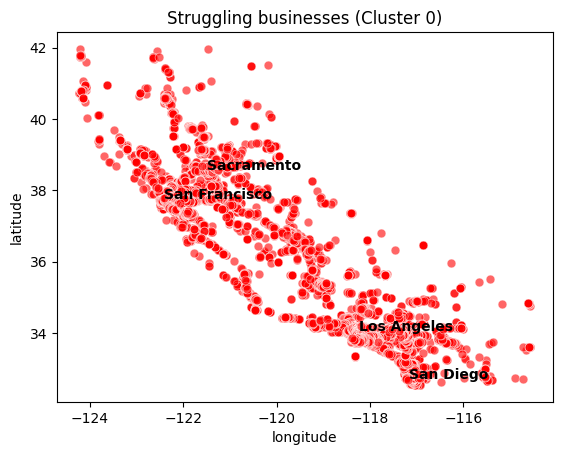

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df_kmeans = df_kmeans[
    (df_kmeans["longitude"] >= -125) & (df_kmeans["longitude"] <= -113) &
    (df_kmeans["latitude"] >= 32) & (df_kmeans["latitude"] <= 43)
]
top_cluster = df_kmeans[df_kmeans["cluster"] == 0]

sns.scatterplot(
    data=top_cluster,
    x="longitude",
    y="latitude",
    color="red",
    alpha=0.6,
    s=40
)
for city, (lon, lat) in city_coords_ca.items():
    plt.text(lon, lat, city, fontsize=10, weight="bold")

plt.title("Struggling businesses (Cluster 0)")

Text(0.5, 1.0, 'Hidden Gems (Cluster 1)')

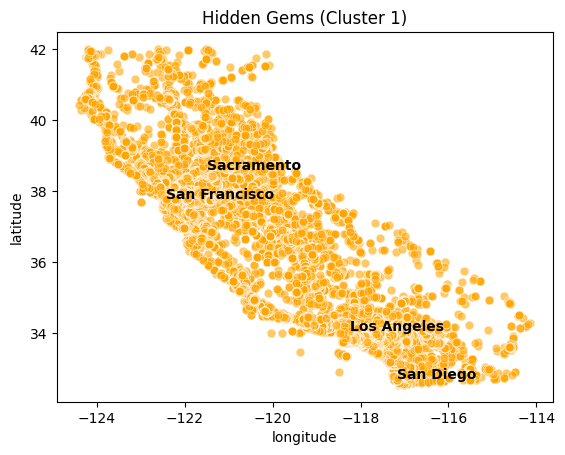

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df_kmeans = df_kmeans[
    (df_kmeans["longitude"] >= -125) & (df_kmeans["longitude"] <= -113) &
    (df_kmeans["latitude"] >= 32) & (df_kmeans["latitude"] <= 43)
]
top_cluster = df_kmeans[df_kmeans["cluster"] == 1]

sns.scatterplot(
    data=top_cluster,
    x="longitude",
    y="latitude",
    color="orange",
    alpha=0.6,
    s=40
)
for city, (lon, lat) in city_coords_ca.items():
    plt.text(lon, lat, city, fontsize=10, weight="bold")

plt.title("Hidden Gems (Cluster 1)")

Text(0.5, 1.0, 'Average Players (Cluster 2)')

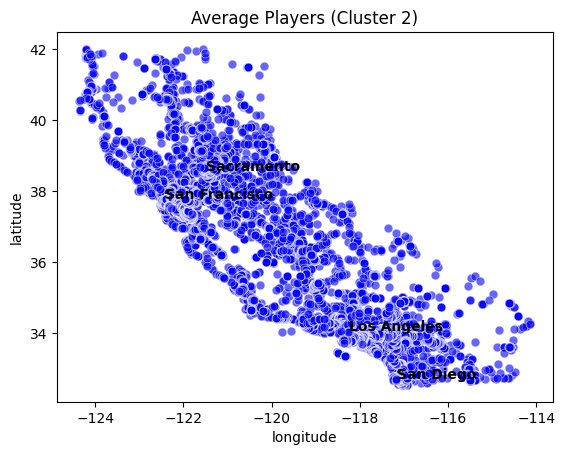

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

df_kmeans = df_kmeans[
    (df_kmeans["longitude"] >= -125) & (df_kmeans["longitude"] <= -113) &
    (df_kmeans["latitude"] >= 32) & (df_kmeans["latitude"] <= 43)
]
top_cluster = df_kmeans[df_kmeans["cluster"] == 2]

sns.scatterplot(
    data=top_cluster,
    x="longitude",
    y="latitude",
    color="blue",
    alpha=0.6,
    s=40
)
for city, (lon, lat) in city_coords_ca.items():
    plt.text(lon, lat, city, fontsize=10, weight="bold")

plt.title("Average Players (Cluster 2)")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_kmeans = df_kmeans[
    (df_kmeans["longitude"] >= -125) & (df_kmeans["longitude"] <= -113) &
    (df_kmeans["latitude"] >= 32) & (df_kmeans["latitude"] <= 43)
]
top_cluster = df_kmeans[df_kmeans["cluster"] == 3]

sns.scatterplot(
    data=top_cluster,
    x="longitude",
    y="latitude",
    color="green",
    alpha=0.6,
    s=40
)
for city, (lon, lat) in city_coords_ca.items():
    plt.text(lon, lat, city, fontsize=10, weight="bold")

plt.title("Top-Performers (Cluster 3)")

In [17]:
top_in_cluster = df_kmeans[df_kmeans['cluster'] == 3].sort_values(by='num_of_reviews', ascending=False).head()
top_in_cluster

gmap_id      customer_name  rating  \
303349  0x80deab043d0c63e5:0xa61214169a0cdb0a      Daniel Lipton       3   
108796  0x808580668e8f3159:0x6cf7a313d6a53ec7      Michael Saxby       5   
149326  0x80dd1ffeb7628365:0x1f6a4c1815205025  Aley Eldin Tohamy       4   
191543  0x80d951fb495fe7f1:0xf67bc8a99bedc791     Natasha Valdez       5   
5488    0x808586d510144681:0xe960db8a581aacf5    Marija Dordevic       5   

                                                  reviews           time  \
303349  As a piece of history, this is a fascinating s...  1616523208295   
108796  Great views of the Bay and quite a few interes...  1617203383685   
149326  Amazing place, nice weather but a lot of peopl...  1617040488281   
191543  I love this mall! They had everything I wanted...  1617690834583   
5488    This is absolutely must see, if you are visiti...  1620943816541   

        avg_rating                                           category  \
303349         4.7  Community center, Art center, Art gallery, Art...   
108796         4.6         Historical landmark, Ferry service, Market   
149326         4.6     Fishing pier, Public beach, Tourist attraction   
191543         4.5  Shopping mall, Clothing store, Department stor...   
5488           4.7  Event venue, Corporate entertainment service, ...   

         latitude   longitude            business_name  ...  Saturday Sunday  \
303349  32.737601 -117.213472          Liberty Station  ...       1.0    1.0   
108796  37.795838 -122.393780           Ferry Building  ...       1.0    1.0   
149326  33.607468 -117.928811       Newport Beach Pier  ...       1.0    1.0   
191543  32.655904 -117.065485   Westfield Plaza Bonita  ...       1.0    1.0   
5488    37.802931 -122.448423  The Palace Of Fine Arts  ...       1.0    1.0   

                  timestamp  week  month  year  time_seconds  label  \
303349  2021-03-23 18:13:28    12      3  2021    1616523208      1   
108796  2021-03-31 15:09:43    13      3  2021    1617203383      2   
149326  2021-03-29 17:54:48    13      3  2021    1617040488      1   
191543  2021-04-06 06:33:54    14      4  2021    1617690834      2   
5488    2021-05-13 22:10:16    19      5  2021    1620943816      2   

        sentiment_encoded  cluster  
303349                NaN        3  
108796                NaN        3  
149326                NaN        3  
191543                NaN        3  
5488                  NaN        3  

[5 rows x 28 columns]

In [18]:
!pip install geopandas contextily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.5 MB/s eta 0:00:00


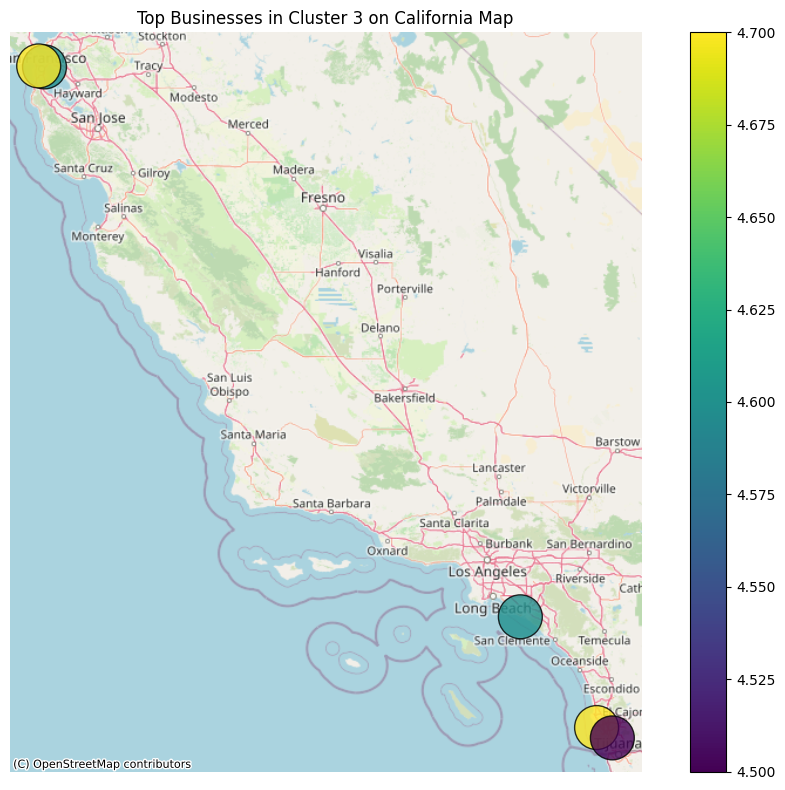

In [19]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Create geometry column (longitude = x, latitude = y)
top_in_cluster["geometry"] = top_in_cluster.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)

# Convert to GeoDataFrame and set coordinate system
gdf = gpd.GeoDataFrame(top_in_cluster, geometry="geometry", crs="EPSG:4326")

# Convert to Web Mercator for contextily tile compatibility
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    markersize=gdf["num_of_reviews"] / 10,
    column="avg_rating",
    cmap="viridis",
    edgecolor="black",
    legend=True,
    alpha=0.8
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Top Businesses in Cluster 3 on California Map")
ax.axis("off")
plt.tight_layout()
plt.show()